In [2]:
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np

import virl

### Tabular Q-learning

This script trains an agent using traditional Q-learning. This involves approximating a $Q(s,a)$ table that stores an estimation of discounted future reward for taking action $a$ in state $s$. The table will contain an entry for every state action pair. 

#### Discretization

Because this is a continuous task, we must first discretize the state space into bins, however it is not immediately obvious how many bins to have and what scale should be used. Too many states and the agent will not be able to learn anything as the state space is too big, too few and it will not have enough distinguishing power to make sensible choices. It must also be considered whether to use a linear or logarithmic scale to allocate to different bins. As a result discretization method essentially becomes a hyperparameter of the training process. 

The general approach here is to structure the Q table as a 5 dimensional numpy array, one dimension for each of the 4 state variables and one for the action. This means an index such as `Q[1,2,3,4,0]` would represent the estimated Q-value for taking action 0 when s[0] falls into bin 1, s[1] falls into bin 2, s[2] falls into bin 3 and s[3] falls into bin 4.

Discretization will be handled by the `discretize()` function which will take the current continuous state, total population (in this case `np.sum(s)`) and the number of bins, and return a discretete state space.

#### Learning Q values

The key equation for Q learning is the update rule, given as follows $eqn(1)$:

$
Q(s,a) = Q(s,a) + \alpha (R(s) + \gamma \max_{a'}Q(s',a')-Q(s,a) )
$

Where $Q(s,a)$ is the Q value for the current state action pair $a$, $s$. $\alpha$ is the learning rate. $R(s)$ is the reward for state $s$. $\gamma$ is the discount factor. $Q(s',a')$ is the Q value for the new state $s'$ after taking action $a$ in state $s$, and the best known action $a'$ in that state $s'$.

The psuedocode for learning the Q values is as follows:

```
initialize Q table as 5d numpy array of zeros
initialize epsilon
for each episode:
    reset state to initial state
    while state is not terminal:
        discretize state
        
        action is index of max value of Q[s[0], s[1], s[2], s[3], :]
        if rand < epsilon:
            make action random
        
        store the value of Q[s[0], s[1], s[2], s[3], action]
        
        take action and get new state, and reward
        discretize new state
        
        best action is index of max value of Q[new_s[0], new_s[1], new_s[2], new_s[3], :]
        store Q[new_s[0], new_s[1], new_s[2], new_s[3], best]
        
        calculate new value for Q[s[0], s[1], s[2], s[3], action] according to eqn(1) above
    end while
    reduce epsilon size
end for

```

In [62]:
env = virl.Epidemic(stochastic=False, noisy=False, problem_id=0)

bins = 20
learning_rate = 0.1
discount_factor = 0.95

def discretize(s, population=600000000, bins=bins):
    bins = np.geomspace(1, population, num=bins)
    return np.digitize(s, bins=bins)

episodes = 1000
avg_episode_rewards = []
Q = np.zeros((bins,bins,bins,bins, env.action_space.n))
epsilon = 1.0
for i in range(episodes):
    states = []
    rewards = []
    done = False

    s = env.reset()
    states.append(s)
    while not done:
        discretized_s = discretize(s)
        action = np.argmax(Q[(*discretized_s, None)])
        if np.random.random() < epsilon:
            action = np.random.choice(env.action_space.n)
        
        q_sa = Q[(*discretized_s, action)]
        
        s, r, done, _ = env.step(action=action)
        
        discretized_new_s = discretize(s)
        s_next_q_values = np.argmax(Q[(*discretized_new_s, None)])
        best_s_next_q_value = Q[(*discretized_new_s, s_next_q_values)]
        
        new_q_sa = q_sa + learning_rate + (r + discount_factor * best_s_next_q_value - q_sa)
        
        Q[(*discretized_s, action)] = new_q_sa
        
        states.append(s)
        rewards.append(r)
    if epsilon > 0.001:
        epsilon*= 0.995
    if i % 50 == 0:
        print(i, "avg", sum(rewards) / len(rewards), "eps", epsilon, "Q", Q.sum())
    avg_episode_rewards.append(sum(rewards) / len(rewards))

0 avg -0.030398179594037414 eps 0.995 Q 3.9726828107503316
50 avg -0.028316467019318597 eps 0.7744209942832988 Q 442.58707435834935
100 avg -0.029494206367670025 eps 0.6027415843082742 Q 754.1478354622113
150 avg -0.022808168854141806 eps 0.46912134373457726 Q 905.7006851632266
200 avg -0.02233317262971805 eps 0.36512303261753626 Q 975.3385922337753
250 avg -0.021547455690850002 eps 0.28417984116121187 Q 1023.771483291863
300 avg -0.02210311523476841 eps 0.2211807388415433 Q 1055.6034528589844
350 avg -0.019588724536109006 eps 0.17214774642209296 Q 1081.6597711629163
400 avg -0.020460112255321742 eps 0.13398475271138335 Q 1087.989242189639
450 avg -0.02061064854230666 eps 0.1042820154910064 Q 1096.4098187837242
500 avg -0.020190011975277526 eps 0.0811640021330769 Q 1108.5702973852262
550 avg -0.02208621007669073 eps 0.06317096204211972 Q 1116.976260824362
600 avg -0.02259470827632818 eps 0.04916675299948831 Q 1117.2436540266992
650 avg -0.01773477298357195 eps 0.03826710124979409 Q 111

total reward -0.8348912245574281


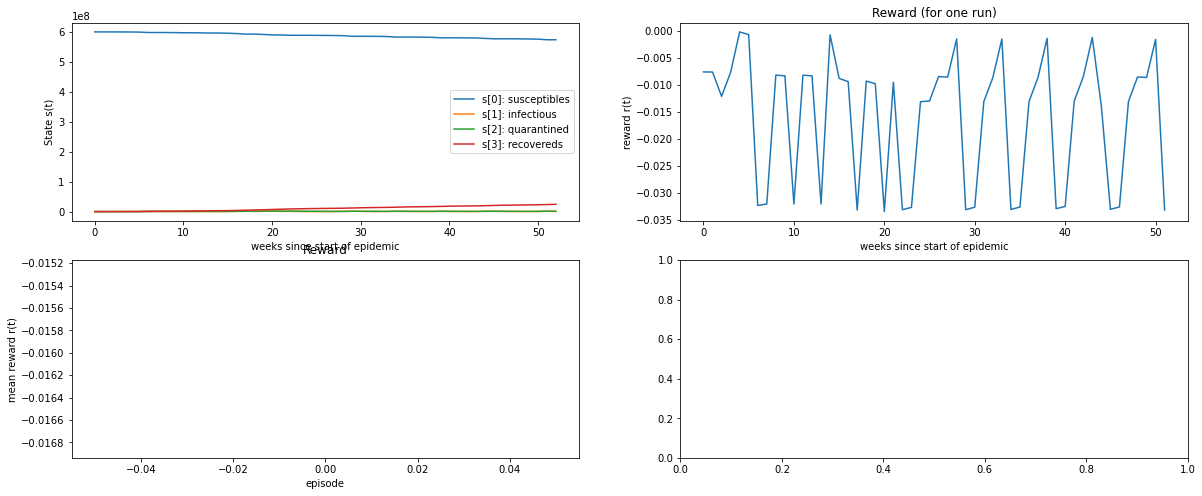

In [86]:

def analysis(states, rewards, avg_episode_rewards):
    fig, axes = plt.subplots(2, 2, figsize=(20, 8))
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(states)
    for i in range(4):
        axes[0, 0].plot(states[:,i], label=labels[i]);
    axes[0, 0].set_xlabel('weeks since start of epidemic')
    axes[0, 0].set_ylabel('State s(t)')
    axes[0, 0].legend()
    axes[0, 1].plot(rewards);
    axes[0, 1].set_title('Reward (for one run)')
    axes[0, 1].set_xlabel('weeks since start of epidemic')
    axes[0, 1].set_ylabel('reward r(t)')
    axes[1, 0].plot(avg_episode_rewards);
    axes[1, 0].set_title('Reward')
    axes[1, 0].set_xlabel('episode')
    axes[1, 0].set_ylabel('mean reward r(t)')

    print('total reward', np.sum(rewards))

def execute_policy(policy, env):
    """Execute a policy

    :param policy a policy to run. A policy is a callable that takes a state as input and returns an array of probabilities of actions. If the policy returns a tuple the first element is taken.
    :param env the environment to run (a correctly instantiated problem).

    :returns a tuple (states, rewards, action_taken)
    """
    s = env.reset()

    states = [s]
    rewards = []
    action_taken = []
    done = False

    while not done:
        s = states[-1]
        action_id = policy(s)

        s, r, done, i = env.step(action=action_id)

        states.append(s)
        rewards.append(r)
        action_taken.append(action_id)

    return states, rewards, sum(rewards) / len(rewards)

def policy(s):
    discretized = discretize(s)
    q = Q[(*discretized, None)][0]
    return np.argmax(q)


states, rewards, avg_episode_rewards = execute_policy(policy, virl.Epidemic(stochastic=False, noisy=False, problem_id=4))
analysis(states, rewards, avg_episode_rewards)